# Visualizing Meter Signals of EV- and non-EV-Homes

I have two months (2880 30-minute intervals) of meter signal per house. How many intervals do I need to identify 100% of the homes which have EVs (i.e. will an EV home always have an EV charge within the first 48 hours? 96 hours?)

In [1]:
# Library Imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
%matplotlib inline

## Load and Prep Data

Generally when I'm working with EV_train and EV_train_labels, I start out with the following prep:
  - Drop rows in EV_train with blank values. There are only a few rows (out of about 1500), and for ML I prefer to train models on real vs interpolated data when it doesn't require throwing away too much data. Dropping these few rows upfront here also avoids some headaches in this notebook with seasonal-decomposition later on.
  - Reshape EV_train data so that the time ('Interval') dimension is in one column. This lets me do more with Pandas DataFrame.apply()

In [2]:
# Load Data
EV_train        = pd.read_csv('EV_files/EV_train.csv')
EV_train_labels = pd.read_csv('EV_files/EV_train_labels.csv')

In [3]:
# Drop Rows with any blank meter-readings
def get_blank_row_indices(df):
    '''Return row-indices with any blank values'''
                        
    blanks_per_row   = df.isnull().sum(axis=1)
    rows_with_blanks = blanks_per_row[blanks_per_row>0].index

    return rows_with_blanks

rows_with_blanks = get_blank_row_indices(EV_train)
print("rows with blanks: " + str(rows_with_blanks))

# No blanks in EV_train_labels. But rows we drop from X (for blanks) need to also be dropped from Y
EV_train        = EV_train.drop(rows_with_blanks)
EV_train_labels = EV_train_labels.drop(rows_with_blanks)

rows with blanks: Int64Index([290, 539, 1159, 1374], dtype='int64')


In [4]:
# Reshape EV_train so time 'Interval' is one-column w/ many levels, instead of 2880 diff columns
def reshape_long(df, value_col_name=''):
    '''Convert EV_train/labels from matrix shape to long column of values, 
        with ID/Interval each as columns (so available for pd.groupby() )
    '''
    
    #Reshape matrix to flat column of values, with additional cols for id/interval
    reshaped = df.set_index('House ID').stack().reset_index()
    
    #Rename Columns
    reshaped.columns=(['House ID', 'Interval', value_col_name])
    
    #Convert 'Time Interval' Values to e.g. '1' instead of 'Interval_1' 
    reshaped['Interval'] = reshaped['Interval'].str[9:].astype(int)        
    
    return reshaped    

EV_train_reshaped = reshape_long(EV_train, value_col_name='Meter Reading')

## How many Intervals Does it take to identify an EV home?

I define an "EV home" as any home which had an EV charge at least once over our two months of data. 

It would be awesome if EV-homes were identifiable within the first few days (i.e. if EV-homes always had an EV-charge within the first few days of data). The reasons this would be encouraging are:
  - Plots of meter readings are clearer when looking at a few days' of data than all 2880 intervals together
  - Two or three days of data would be on the order of 100-150 intervals. 100-150 intervals means we could pass the raw signal as 100-150 features to a neural network and might get a pretty good result even without much feature engineering. 

In [5]:
def flag_EV_by_house(EV_labels):
    ''' Convert EV_labels from (m x n) shape (houses x intervals) to 1d array of 1/0 flags for whether EV ever
        charged at that house or not
    '''
    # index on House ID
    EV_labels = EV_labels.set_index('House ID', drop=True)
    
    # Max() Value Across Rows is 1 if EV ever Charged at that House, 0 if not
    result_series = EV_labels.apply(max, axis=1)
    result_series.name = 'EV at House'
    
    return result_series

In [6]:
# Get EV-status by Home (Using all Intervals)
EV_status_by_home = flag_EV_by_house(EV_train_labels)

# Get EV-status by Home, Using only First-N Intervals (2 Intervals per Hour)
EV_charges_by_12hrs = flag_EV_by_house(EV_train_labels.iloc[:, :24])
EV_charges_by_18hrs = flag_EV_by_house(EV_train_labels.iloc[:, :36])
EV_charges_by_24hrs = flag_EV_by_house(EV_train_labels.iloc[:, :48])
EV_charges_by_36hrs = flag_EV_by_house(EV_train_labels.iloc[:, :72])
EV_charges_by_48hrs = flag_EV_by_house(EV_train_labels.iloc[:, :96])

# Print % of EV-homes that are identifiable as EV-homes within N Intervals
print(accuracy_score(EV_status_by_home, EV_charges_by_12hrs))
print(accuracy_score(EV_status_by_home, EV_charges_by_18hrs))
print(accuracy_score(EV_status_by_home, EV_charges_by_24hrs))
print(accuracy_score(EV_status_by_home, EV_charges_by_36hrs))
print(accuracy_score(EV_status_by_home, EV_charges_by_48hrs))

0.735182849937
0.813997477932
0.995586380832
0.996216897856
1.0


Notes: So we get to 99.6% ID rate of EV-homes by looking at just the first 24 hours (48 intervals), and to 100%
ID-rate of EV-homes by looking at the first 48 hours.

Now that we know we can identify EV homes based on the first 24-48 hours, it would be interesting to see the meter signals from many houses overlaid on top of each other. If we color on EV-house status, do systematic differences stand out?

## Plotting EV Signals, Colored on EV Status

In [7]:
# Merge EV-home 1/0 flags into EV_train_reshaped meter data (currently shaped long by home by interval)
EV_train_reshaped2 = EV_train_reshaped.merge(EV_status_by_home.reset_index(), how='left', on = "House ID")

# confirm merge didn't change # rows
assert EV_train_reshaped2.shape[0] == EV_train_reshaped.shape[0]

EV_train_reshaped2.head(4)

House ID  Interval  Meter Reading  EV at House
0  11655099         1          0.950            0
1  11655099         2          0.826            0
2  11655099         3          0.361            0
3  11655099         4          0.238            0

In [9]:
# Define Helper Function to use later with Pandas .apply() 
def scale_series(s):
    '''Helper function to use with DF.groupby().apply(). Scale Series to Mean=0, St. Dev=1. '''

    return (s - np.mean(s)) / np.std(s)

### Defining our main Plotting function

In [10]:
def plot_signals(df, meter_reading, EV_home_flag,
                 ax=None,
                 plot_intervals=48, 
                 houses_per_group = 10,
                 normalize_by = None,
                 plot_title = 'Meter Signals. One Line per House.'):

    '''Given a Dataframe with columns for: 
            - Interval
            - House ID
            - meter_reading (colname in df specified by caller. Can pass e.g. raw signal or seasonally adjusted)
            - EV_home_flag  (colname in df specified by caller)
    
        Plot Meter Signals from different homes,superimposed on Same axes. 
        Color by whether an EV is at the house or not.
    
        Options for how many houses(lines) to plot, how many (30-minute) intervals to plot, and 
        how (or whether) to normalize meter readings
    '''
    
    # Input validation. 
    required_columns = ['House ID', 'Interval', meter_reading, EV_home_flag]
    assert set(required_columns).issubset(set(df.columns))
    assert normalize_by in [None, 'House ID', 'Interval', ['House ID', 'Interval']]

    # If not passed a subplot ax object to plot on, create one here 
    if ax == None:
        fig, ax = plt.subplots(figsize=(18,8))

    # Optionally scale data (before any filtering!)
    # NOTE: These two lines are throwing SettingWithCopy Warning. Why? Makes no sense
    if normalize_by != None:
        df[meter_reading] = df.groupby([normalize_by])[meter_reading].transform(scale_series)
    
    # Filter down to param number of intervals for plotting
    df = df[df['Interval']<=plot_intervals].reset_index(drop=True)
    
    # Filter down to param number of houses for plotting
    if houses_per_group != None:
        EV_homes    = np.random.choice(df['House ID'].unique(),    size=houses_per_group)
        nonEV_homes = np.random.choice(df['House ID'].unique(),    size=houses_per_group)
         
        df = df[(df['House ID'].isin(EV_homes)) | (df['House ID'].isin(nonEV_homes))]
    

    #Plot meter readings, one line per house, colored by EV-at-house
    color_mapping = {1:'blue', 0:'green'}
    
    #'House ID' column wholly determines grouping. 
    # Adding EV-Home-Flag so can access it as single-value for Houe-group in key[1] for plot-color
    grouped = df.groupby(['House ID', EV_home_flag])     
    for key, group in grouped:
        EV_flag   = key[1]                  
        
        group.plot(x='Interval', y=meter_reading, 
                   ax=ax,
                   kind = 'line', alpha=0.5, legend=None,
                   color = color_mapping[EV_flag]) #EV-flag, which is EV_home_flag column, has values in (0,1)
    
    # Set plot aesthetics: Axis Labels, Font Size, Legend
    ax.set_title(plot_title, fontsize=18) 
    
    ylabel = "Meter Reading" + ("" if normalize_by == None else " Normalized by " +normalize_by) 
    
    ax.set_ylabel(ylabel,          fontsize=16)    
    ax.set_xlabel('Time Interval', fontsize=16)
    ax.tick_params(labelsize=16)
    
    blue_label    = mpatches.Patch(color='blue', label='Homes with an EV')#, fontsize=16)
    green_label   = mpatches.Patch(color='green', label='Homes without an EV')#, fontsize=16)    
    ax.legend(handles=[blue_label, green_label])

    return ax   

## Plotting Meter Readings

Let's plot meter readings from ten EV- and ten non-EV-houses, for the first 48 hours.

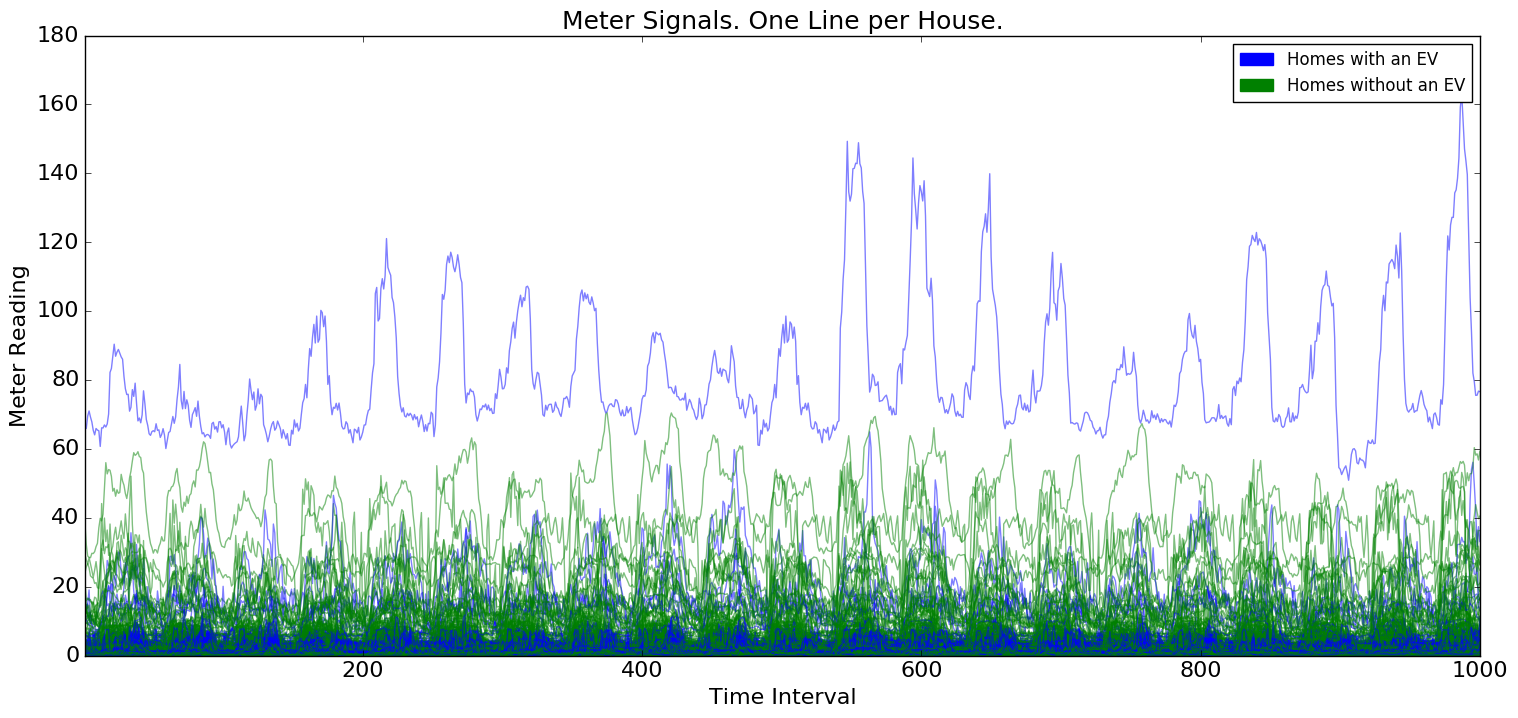

In [25]:
# Plot
plt.close()
plot_signals(df = EV_train_reshaped2, 
             meter_reading='Meter Reading', 
             EV_home_flag = 'EV at House', 
             plot_intervals=1000, 
             houses_per_group = 2800,
             normalize_by = None, #'House ID',
             plot_title = 'Meter Signals. One Line per House.')

## Subplots: Plotting Versions With 10, 50 and 100 Houses Per Category

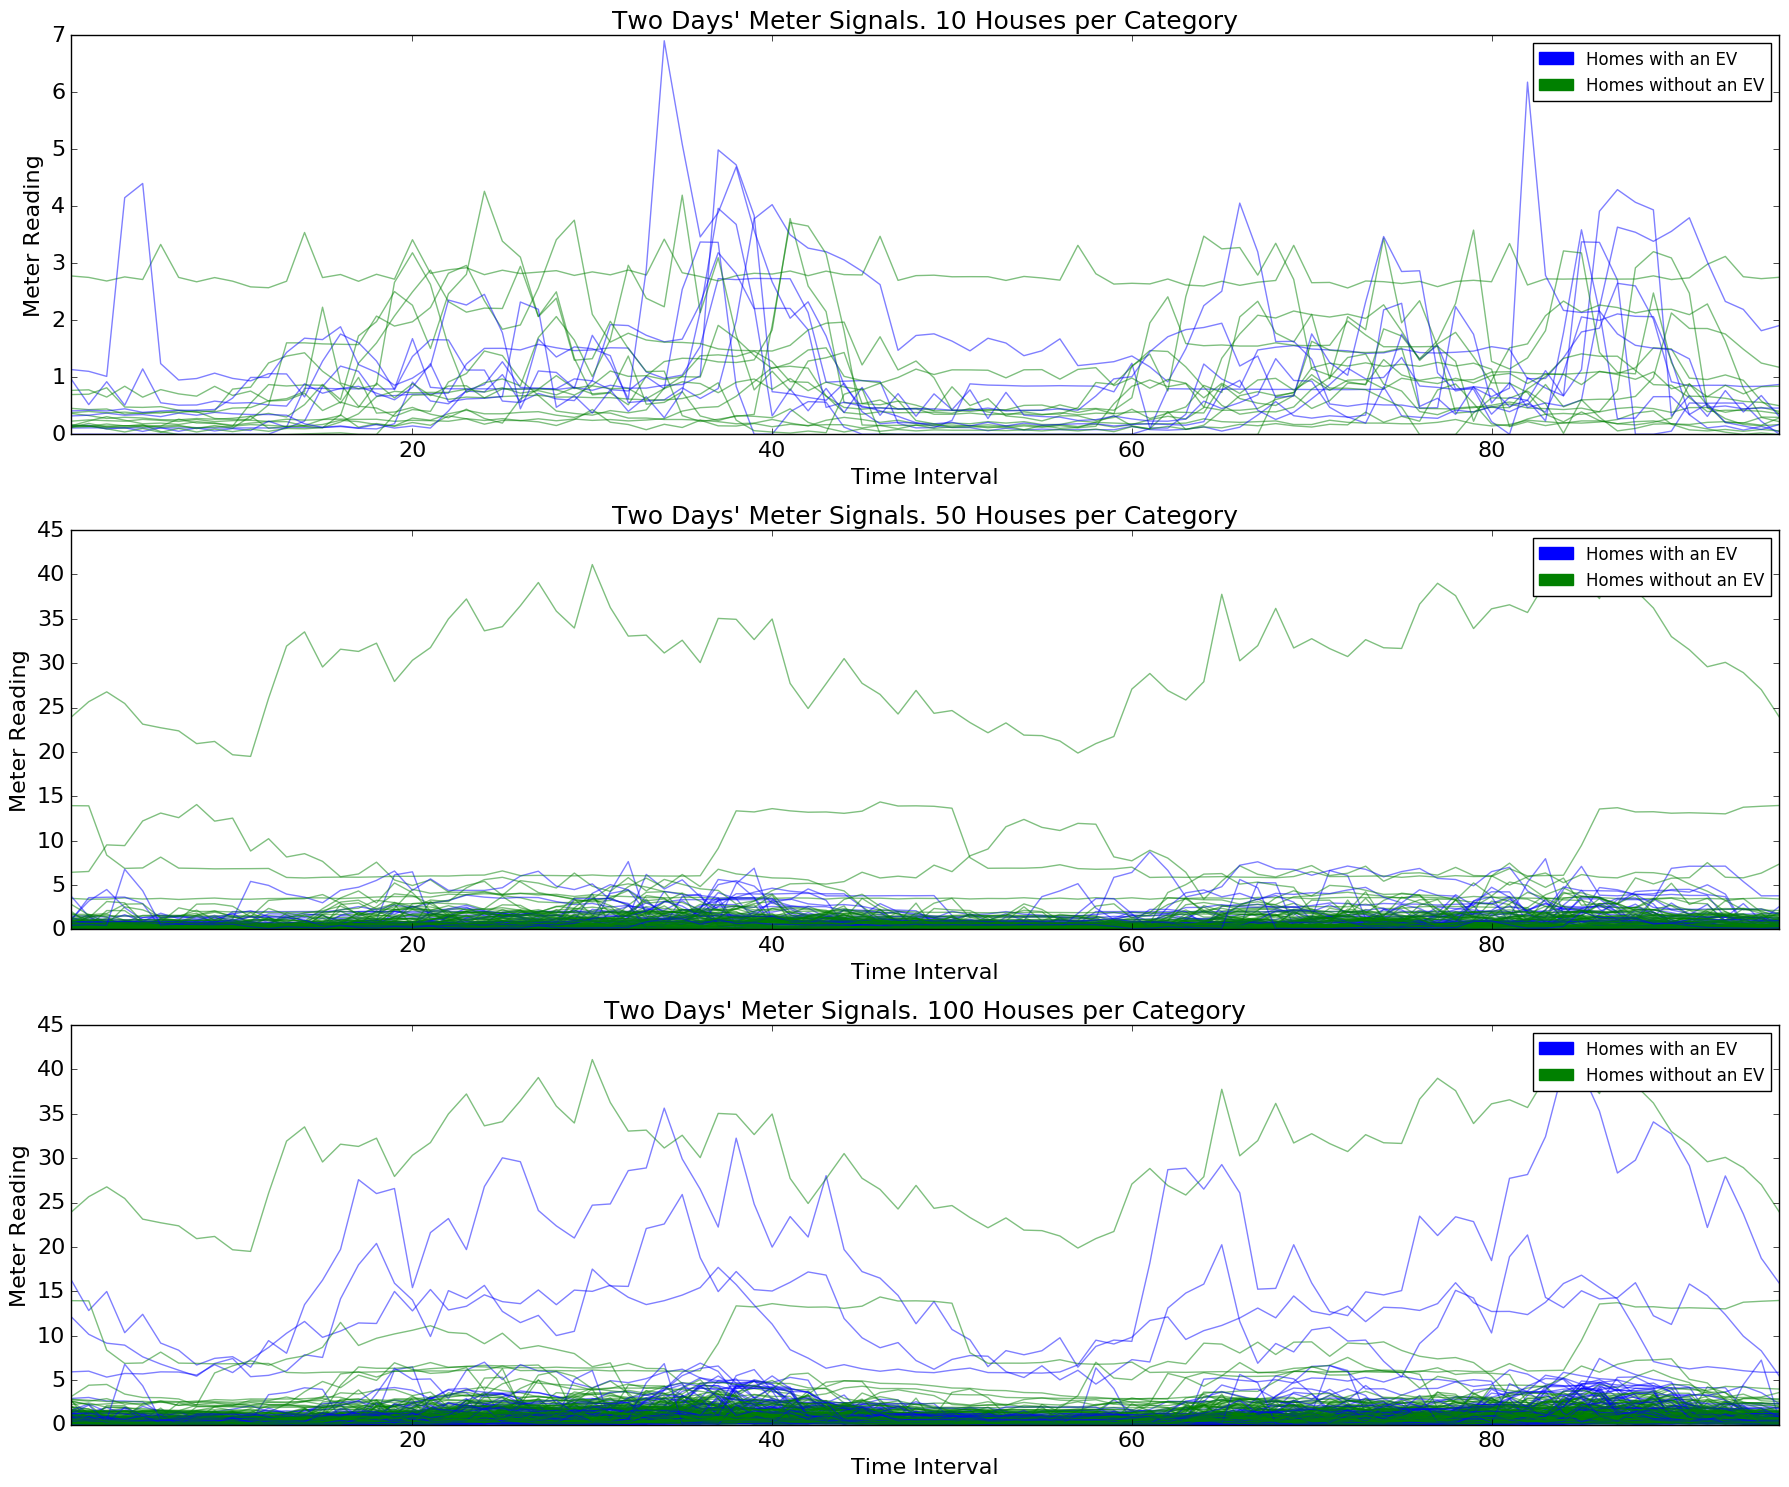

In [132]:
plt.close()
fig, axes = plt.subplots(3,1, figsize=(18,15))
houses = [10,50,100]

for ax, num_houses in zip(axes, houses):
    ax =  plot_signals(df= EV_train_reshaped2, 
                       meter_reading='Meter Reading',
                       EV_home_flag = 'EV at House',
                       ax=ax,
                       plot_intervals=96, #(48 hours) 
                       houses_per_group = num_houses,
                       normalize_by = None, #'House ID',
                       plot_title = "Two Days' Meter Signals. " + str(num_houses) + " Houses per Category")
    
plt.tight_layout()

As we plot many houses, we get some houses pop into our sample with very high electricity demand, squishing the rest of the plot. 

## Subplots: Plotting Versions With Meter Readings Normalized
Let's re-plot with a set number of houses, but different subplots with:
  - Raw Meter Reading
  - Meter Reading Noramalized by House
  - Meter Reading Normalized by Time Interval

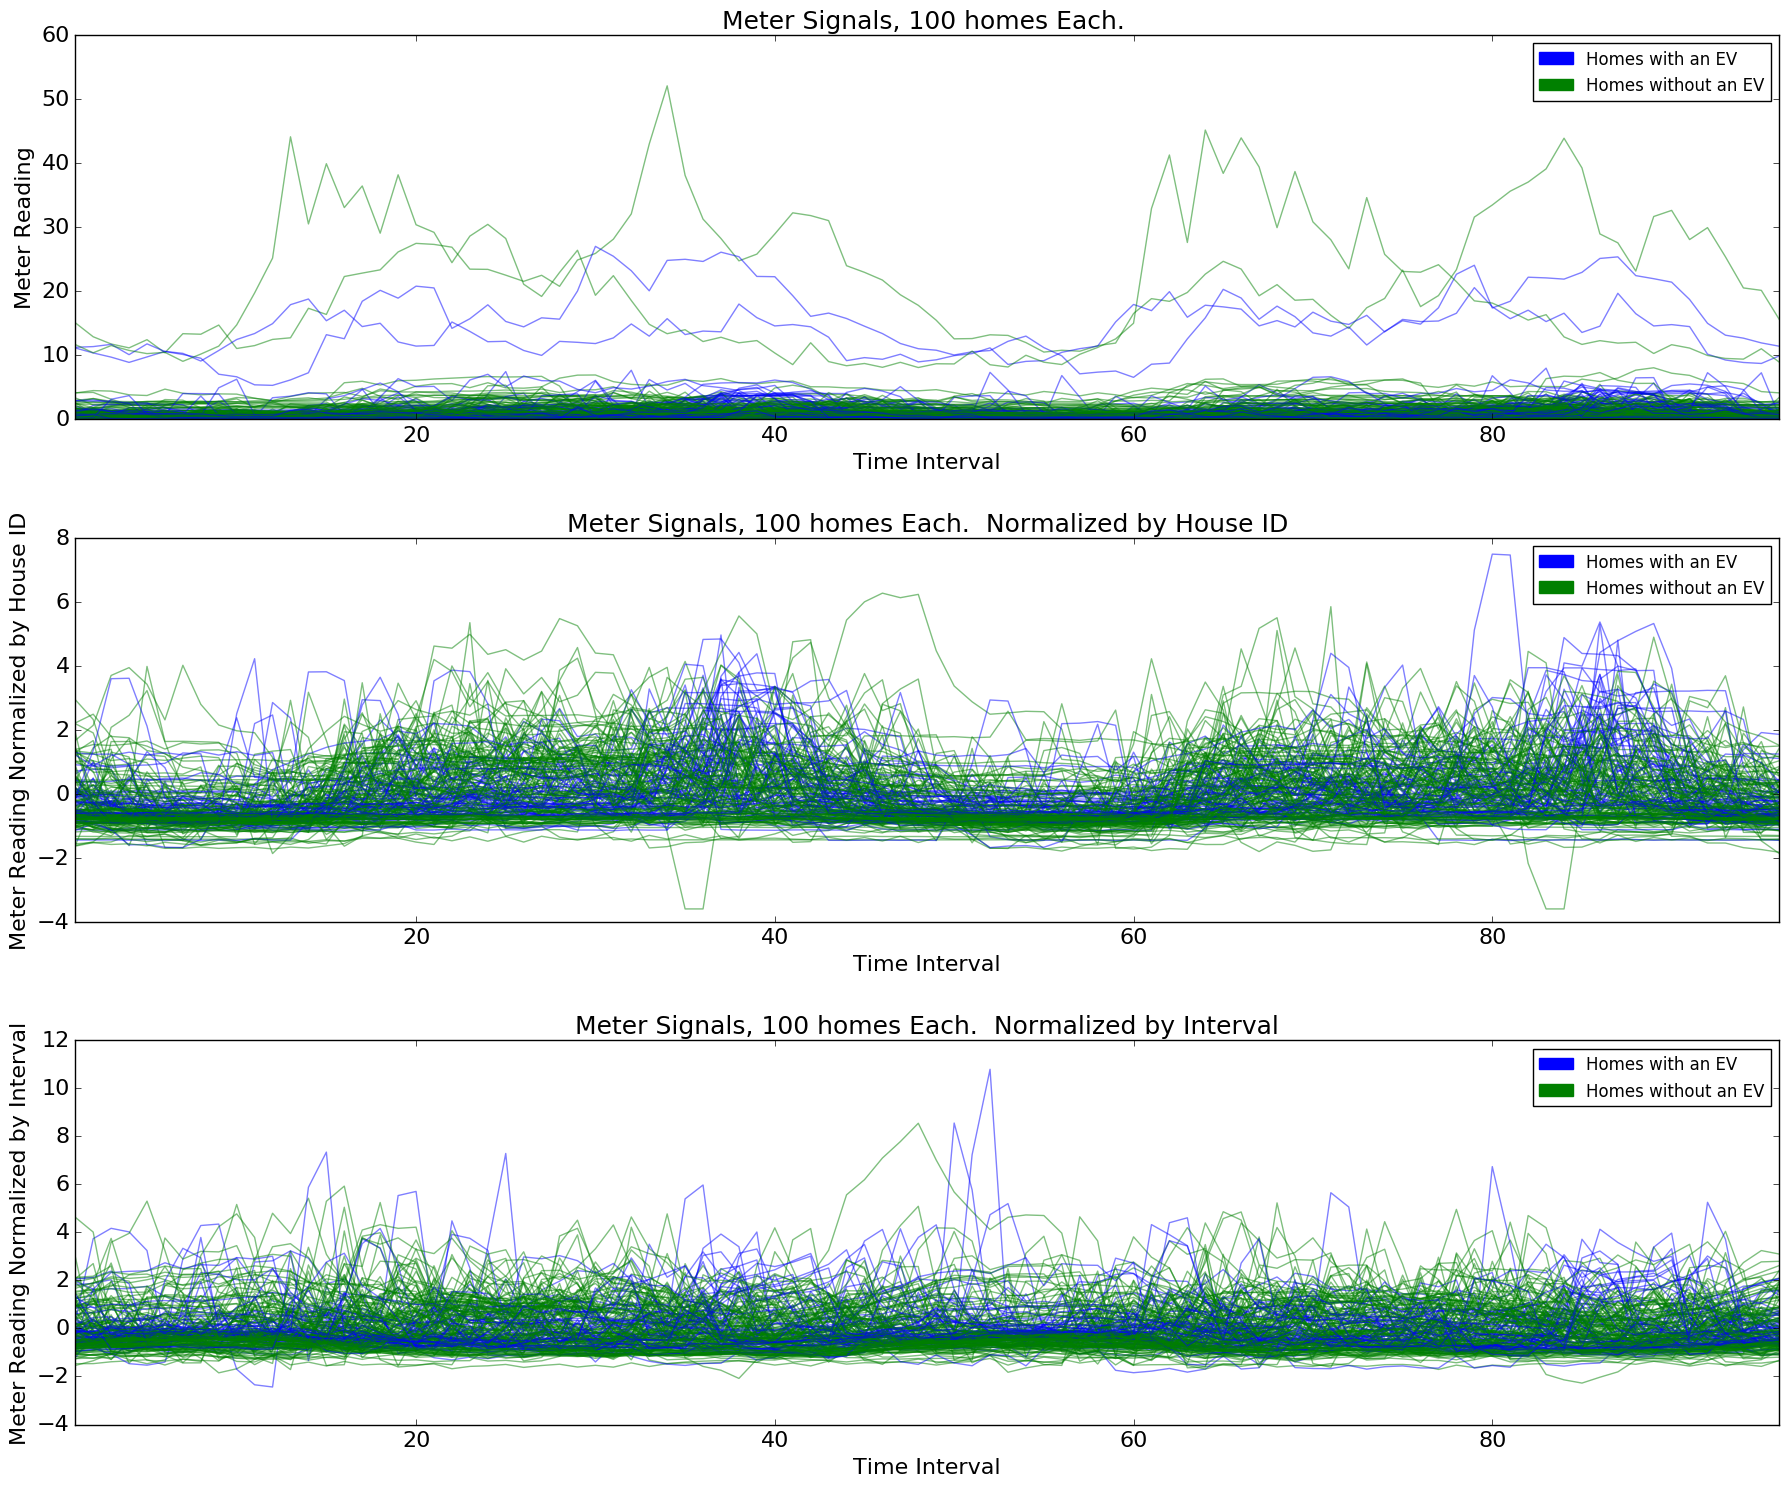

In [133]:
plt.close()
fig2, axes2 = plt.subplots(3,1, figsize=(18,15))
num_houses = 100
norm_options = [None, 'House ID', 'Interval']

for ax, norm in zip(axes2, norm_options):
    
    norm_title = "" if norm==None else " Normalized by " + norm
    
    ax =  plot_signals(df= EV_train_reshaped2, 
                       meter_reading='Meter Reading',
                       EV_home_flag = 'EV at House',
                       ax=ax,
                       plot_intervals=96, #(48 hours) 
                       houses_per_group = num_houses,
                       normalize_by = norm, #None,
                       plot_title = "Meter Signals, 100 homes Each. " + norm_title)
    
plt.tight_layout()

### A few observations on these charts:
  - The normalized charts now have the bulk of the signal below 0. This arithmetically is how the signals remain at mean=0 despite the sharp spikes up in power demand that all houses occasionally have
  - In both normalized charts, normalization was applied upstream of all filtering on houses/intervals.
  - Because I re-sample which 100 homes from each category to plot during each call to plot_intervals(), we're looking at a different batch of houses for each plot. This doesn't bother me too much since we're plotting plenty of houses.
  
### Potential Ideas on Modeling/Features From Any of These Charts?
One potential new feature to use does stand out to me. 
  - It looks to me like average electricity demand is higher during intervals 37-41'ish and 82-88ish among EV-(blue) homes than among non-EV-(green) homes. This seems generally true regardless of if/how meter demand is normalized. I should add average-elec-demand-during-intervals-[] as a feature for classifying whether a home has an EV or not.
 

## Decomping Meter-Readings into Trend / Seasonal / Residual

Now we'll we'll decompose the "Meter Reading" column of (reshaped) EV-train into the following components:
  - Trend
  - Seasonality
  - Residual (e.g. signal after de-trending and seasonally-adjusting)
  

We'll use the StatsModels seasonal_decompose() function. It returns results as attributes of an object, so first let's wrap it in a helper function so we can use it with grouped Pandas Dataframes and .apply() / .transform()

In [134]:
def decompose(s, component, freq=48):
    ''' Decompose signal into seasonality/trend/residual and return 
        component requested by user
    '''    
    
    # input validation
    assert component in ('seasonal', 'trend', 'resid', 'observed')
    
    # Create dictionary with each signal component sm returns as obj attributes
    decomposed = sm.tsa.seasonal_decompose(s, freq=freq)
    components_dict = {'seasonal': decomposed.seasonal,
                       'trend'   : decomposed.trend,
                       'resid'   : decomposed.resid,
                       'observed': decomposed.observed}
                       
    return components_dict[component]


In [135]:
# Add new columns for Trend/Seasonal/Residual Component of Decomposed Meter-Reading(by House)
grouped    = EV_train_reshaped2.groupby(['House ID'])
components = ['seasonal', 'trend', 'resid', 'observed']

for c in components:
    EV_train_reshaped2[c] = grouped['Meter Reading'].transform(lambda s: 
                                                              decompose(s.values, component=c, freq=48))     

After we decompose a signal, the following two things should be true:
  - The new 'observed' column should always equal our original 'Meter Reading' column
  - The new 'trend', 'seasonal' and 'resid' columns should add up to the 'Observed' Column
  
However, it involves calculating a moving average using a sliding window, so it introduces some missing values at the beginning and end of each house group. After dropping those, we can confrim our assumptions above.

In [136]:
# Drop first and last 24 intervals per house, which have blank values for decomposed components
EV_train_reshaped2 = EV_train_reshaped2[(EV_train_reshaped2['Interval'] > 24) & 
                                      (EV_train_reshaped2['Interval'] <= (2880-24))]

In [137]:
# Confirm that the 'Observed' value from seasonal_decompose() is always equal to our original Meter Reading
assert np.array_equal(EV_train_reshaped2['Meter Reading'], EV_train_reshaped2['observed'])

# Confirm that the sum of the decomposed components add up to our original Meter Reading 
summed = EV_train_reshaped2['seasonal'] + EV_train_reshaped2['trend'] + EV_train_reshaped2['resid']
assert np.allclose(EV_train_reshaped2['Meter Reading'], summed)

EV_train_reshaped2.head(10)

House ID  Interval  Meter Reading  EV at House  seasonal     trend  \
24  11655099        25      -0.468960            0 -0.120723 -0.021752   
25  11655099        26       1.545242            0  0.060573 -0.020025   
26  11655099        27       2.970575            0  0.219458 -0.015081   
27  11655099        28       2.302072            0  0.979167 -0.011487   
28  11655099        29       1.481254            0  0.417452 -0.014182   
29  11655099        30       1.714231            0  0.298646 -0.014510   
30  11655099        31       1.726627            0  0.288211 -0.018304   
31  11655099        32       0.500608            0  0.393635 -0.018086   
32  11655099        33      -0.301494            0  0.485437 -0.015998   
33  11655099        34      -0.387243            0  0.427669 -0.018383   

       resid  observed  
24 -0.326485 -0.468960  
25  1.504694  1.545242  
26  2.766198  2.970575  
27  1.334392  2.302072  
28  1.077983  1.481254  
29  1.430094  1.714231  
30  1.456719  1.726627  
31  0.125059  0.500608  
32 -0.770933 -0.301494  
33 -0.796529 -0.387243

### Re-Plotting EV- vs Non-EV-Homes, Using Decomposed Meter Components

Now that we've decomposed our meter readings into trend, seasonal, and residuals (i.e. de-trended + seasonally-adjusted), let's reproduce our previous plots looking at each of these signal components in turn.

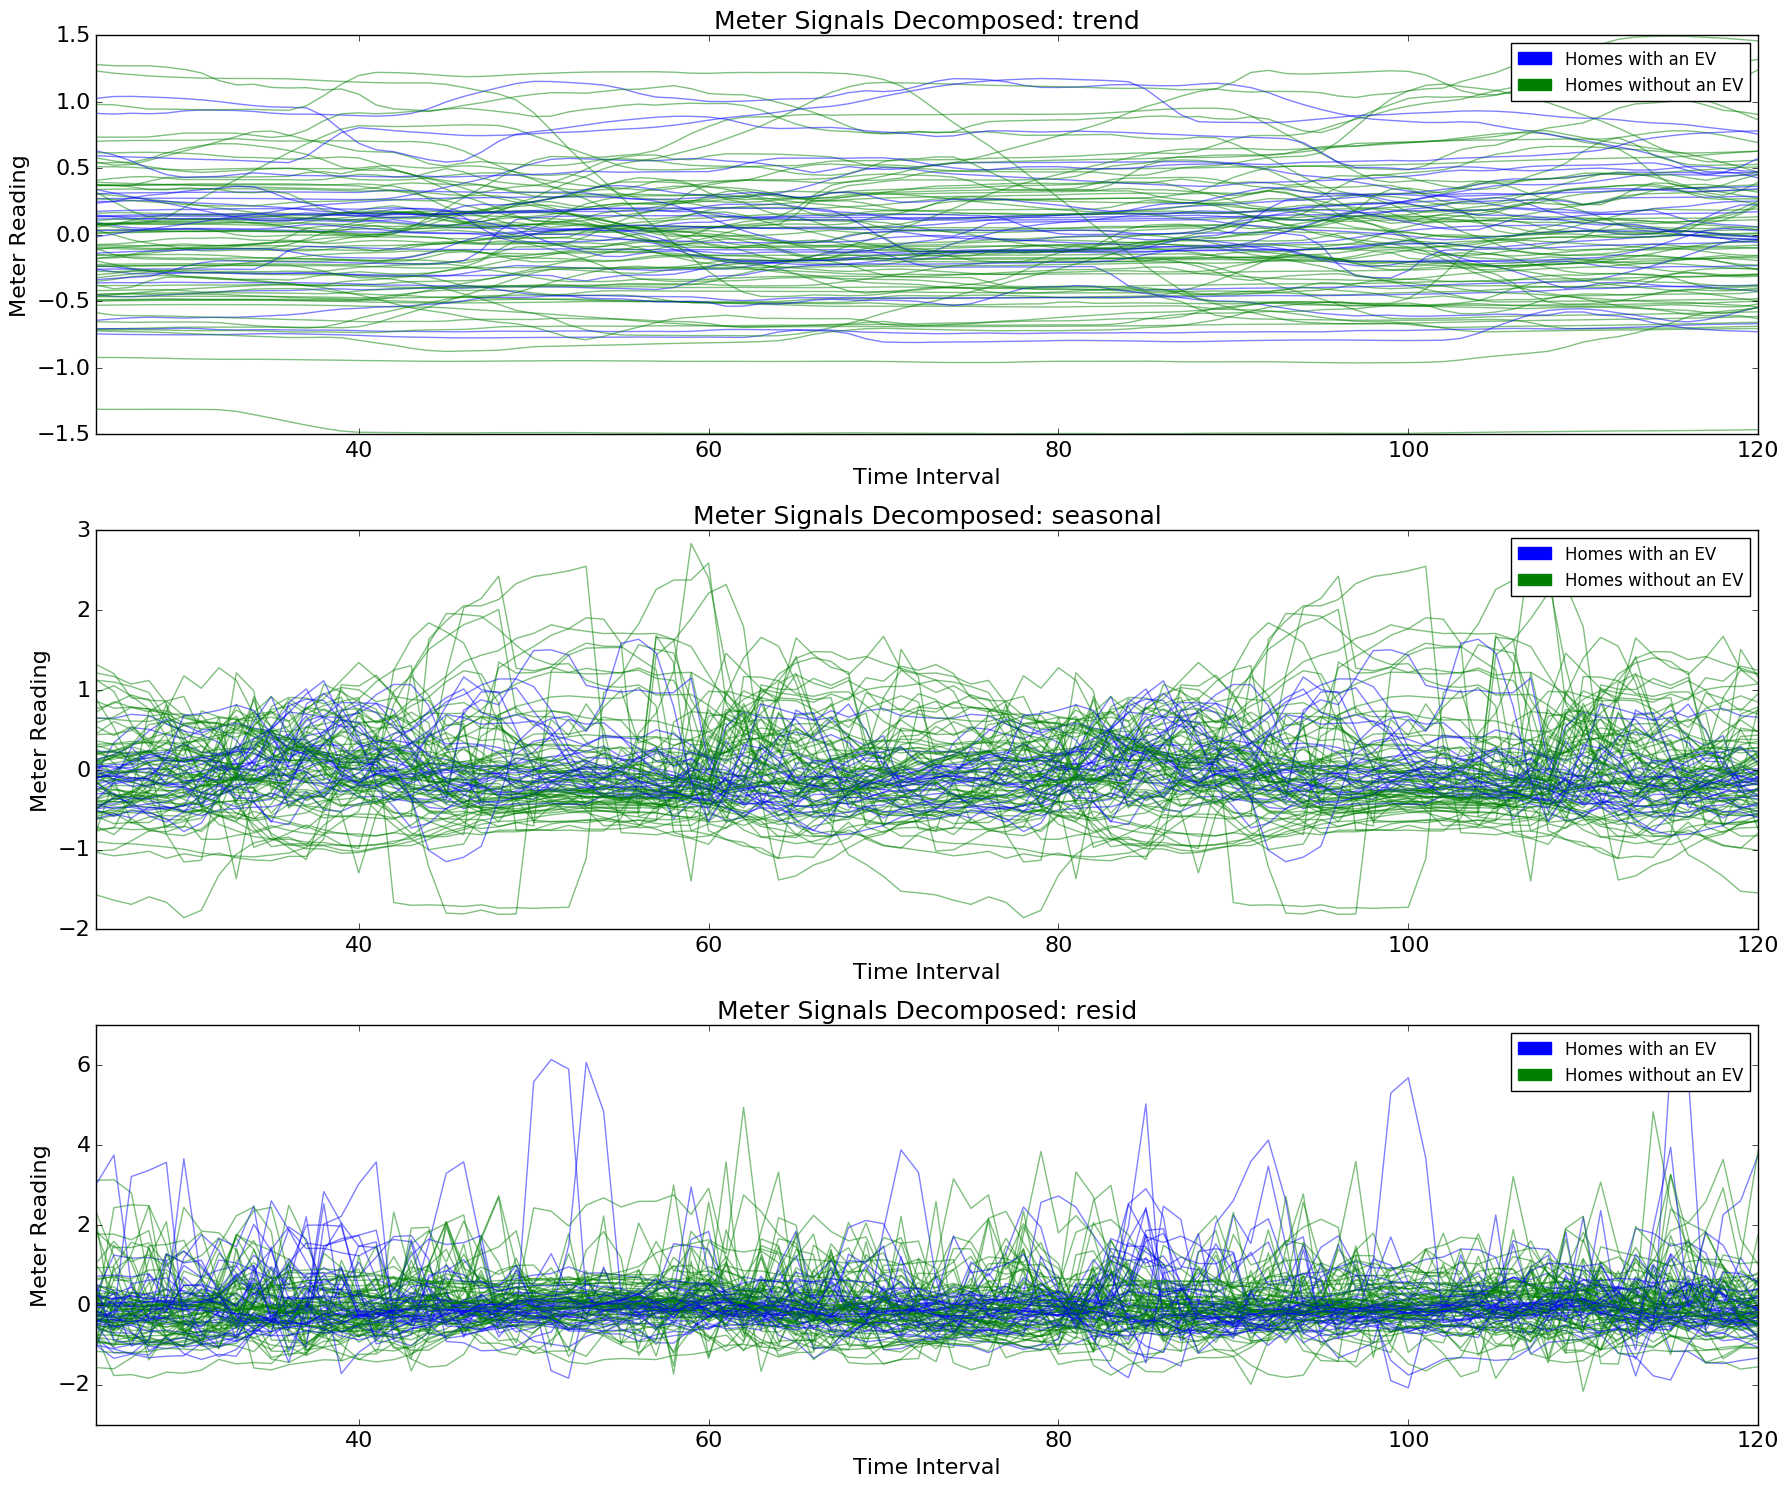

In [138]:
plt.close()
fig3, axes3 = plt.subplots(3,1, figsize=(18,15))
num_houses = 50
signal_components = ['trend', 'seasonal', 'resid']

for ax, signal in zip(axes3, signal_components):
    
    
    ax =  plot_signals(df= EV_train_reshaped2, 
                       meter_reading= signal,
                       EV_home_flag = 'EV at House',
                       ax=ax,
                       plot_intervals=96+24, # plot 96 intervals given first 24 dropped for seasonal calc 
                       houses_per_group = num_houses,
                       normalize_by = None,
                       plot_title = "Meter Signals Decomposed: " + signal)
    
plt.tight_layout()

### Possible Ideas on Modeling/Features from these Charts?

Hm, nothing really strikingly jumps out at me here. 

Maybe the blue lines are more tightly clustered in the middle plot (seasonal component) than the green lines? In that case the standard deviation of the seasonal signal component (calculated by house) might help my model distinguish between EV- and nonEV-homes. 

I was hoping for somethigng like "max residuals of EV homes are consistently higher than max residuals of nonEV homes" though, which does not seem to be the case.